STEP 1:
Take in the degree sequence the first T cluster centres are T largest degree values only. Then classify all of them in respective cluster and update the centres.

In [1]:
def k_means_clustering(degree_sequence, T):
    # Step 1: Sort the input degree sequence
    sorted_degrees = sorted(degree_sequence, reverse=True)
    
    # Initialize clustering centers
    clustering_centers = [sorted_degrees[i] for i in range(T)]
    
    # Initialize dictionary to hold groups
    groups = {i: [] for i in range(T)}
    
    # Repeat until convergence
    while True:
        # Initialize new clustering centers for comparison
        new_centers = [0] * T
        
        # Assign nodes to the corresponding group
        for degree in degree_sequence:
            min_dist = float('inf')
            group_index = None
            for i, center in enumerate(clustering_centers):
                dist = abs(degree - center)
                if dist < min_dist:
                    min_dist = dist
                    group_index = i
            groups[group_index].append(degree)
            new_centers[group_index] += degree
        
        # Recalculate clustering centers
        for i in range(T):
            if groups[i]:
                new_centers[i] /= len(groups[i])
        
        # Check for convergence
        if new_centers == clustering_centers:
            break
        
        # Update clustering centers
        clustering_centers = new_centers.copy()
        
        # Clear groups
        groups = {i: [] for i in range(T)}
    
    return clustering_centers, groups

# Example usage
degree_sequence = [5, 8, 9, 6, 4, 7, 11, 10]  #its the sequence of degree of vertices
num_clusters = 3
centers, groups = k_means_clustering(degree_sequence, num_clusters)
print("Clustering Centers:", centers)
print("Groups:", groups)


Clustering Centers: [10.5, 8.0, 5.0]
Groups: {0: [11, 10], 1: [8, 9, 7], 2: [5, 6, 4]}


STEP 2:From original gp chose any edge (x,y) randomly find the label i,j for x,y via clusters. Add lapclian noise with parameter 1/e and find new i and new j. From this new i,j find new edge randomly if that's not in the new gp G' add it and remove (x,y)

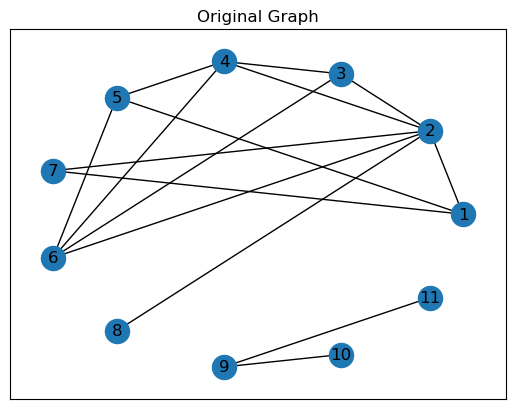

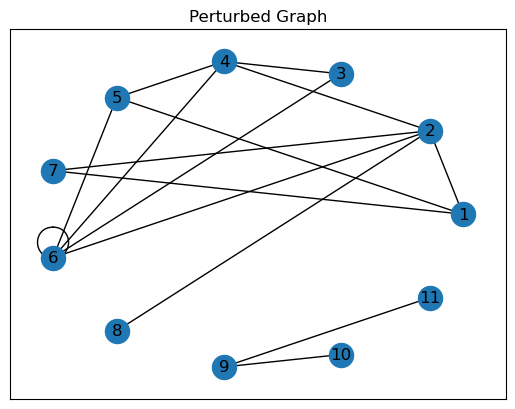

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import copy
# Sample graph
original_graph = nx.Graph()
original_graph.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1),(2,4),(1,7),(2,7),(5,6),(4,6),(2,6),(3,6),(2,8),(9,10),(9,11)])


# Function to visualize graph
def visualize_graph(graph, title):
    pos = nx.circular_layout(graph)
    nx.draw_networkx(graph, pos, with_labels=True)
    plt.title(title)
    plt.show()

visualize_graph(original_graph, "Original Graph")
original_graph_true=copy.deepcopy(original_graph)

def laplace_noise(epsilon):
    """Generate Laplace noise with scale 1/epsilon."""
    scale = 1 / epsilon
    return np.random.laplace(0, scale)
def random_disturbance(original_graph, K, epsilon1):
    """Random disturbance algorithm based on groups for pre-processing."""
    # Get degree sequence of nodes
    degree_sequence = [degree for _, degree in original_graph.degree()]
    
    # Calculate privacy budget for each disturbance iteration
    epsilon_once = epsilon1 / K
    
    # Perform K-means clustering
    T = 5 # Number of clusters
    clustering_centers, groups = k_means_clustering(degree_sequence, T)
    
    # Execute disturbance K times
    for _ in range(K):
        # Randomly select an edge (X, Y) from the reconstruction graph
        X, Y = random.choice(list(original_graph.edges()))
        
        # Calculate minimal distance measures and obtain group labels
        X_degree = original_graph.degree(X)
        Y_degree = original_graph.degree(Y)
        
        min_dist_X = min(abs(X_degree - center) for center in clustering_centers)
        min_dist_Y = min(abs(Y_degree - center) for center in clustering_centers)
        
        i = min(range(len(clustering_centers)), key=lambda x: abs(clustering_centers[x] - X_degree))
        j = min(range(len(clustering_centers)), key=lambda x: abs(clustering_centers[x] - Y_degree))
        
        # Calculate Laplace noises for group labels
        eta1 = laplace_noise(epsilon_once)
        eta2 = laplace_noise(epsilon_once)
        
        # Add Laplace noises to group labels, ensuring the resulting index stays within the valid range
        i_prime = max(0, min(T - 1, i + eta1))
        j_prime = max(0, min(T - 1, j + eta2))
        
        # Randomly select nodes X' and Y' from the groups i' and j', respectively
        # If the group is empty, keep adding noise until a non-empty group is found
        while not groups[int(i_prime)]:
            eta1 = laplace_noise(epsilon_once)
            i_prime = max(0, min(T - 1, i + eta1))
        while not groups[int(j_prime)]:
            eta2 = laplace_noise(epsilon_once)
            j_prime = max(0, min(T - 1, j + eta2))
        
        X_prime = random.choice(groups[int(i_prime)])
        Y_prime = random.choice(groups[int(j_prime)])
        
        # If the edge (X', Y') does not exist in the reconstruction graph, add it and delete edge (X, Y)
        if not original_graph.has_edge(X_prime, Y_prime):
            original_graph.add_edge(X_prime, Y_prime)
            original_graph.remove_edge(X, Y)
    
    return original_graph

# Example usage
K = 5
epsilon1 = 0.033
perturbed_graph = random_disturbance(original_graph, K, epsilon1)
visualize_graph(perturbed_graph, "Perturbed Graph")


STEP 3: Here noises are added to degree sequence but in more stricter way avoiding redundant noises.
Lapclian (noise) Mechanism is used since its efficent in avoiding redudant noises and keeping the process of noise generation random.

In [3]:
def noise_allocation_laplace_mechanism(groups, epsilon2):
    """Noise allocation algorithm based on Laplace mechanism."""
    noisy_groups = {}
    
    # Iterate over each group
    for group_index, degree_sequence in groups.items():
        noisy_degree_sequence = degree_sequence.copy()
        
        # Calculate sensitivity for Laplace mechanism
        sensitivity = max(degree_sequence) - min(degree_sequence)
        
        # Calculate Laplace noise
        laplace_noise_total = laplace_noise(epsilon2)
        
        # Distribute noise randomly to nodes in the group
        while laplace_noise_total > 0:
            # Choose a random node from the group
            node_index = random.randint(0, len(noisy_degree_sequence) - 1)
            
            # Add Laplace noise to the node
            noisy_degree_sequence[node_index] += 1
            
            # Reduce the total noise
            laplace_noise_total -= 1
        
        # Update the noisy group
        noisy_groups[group_index] = noisy_degree_sequence
    
    return noisy_groups

# Example usage
def test_noise_allocation_laplace_mechanism():
    # Use the perturbed graph and its degree sequences
    degree_sequences = {}
    for node in perturbed_graph.nodes():
        degree_sequences[node] = [degree for _, degree in perturbed_graph.degree([node])]
    print("This is the earlier degree sequence:")
    print(degree_sequences)
    # Privacy budget
    epsilon2 = 0.033
    
    # Apply noise allocation for each group
    noisy_groups = noise_allocation_laplace_mechanism(degree_sequences, epsilon2)
    
    # Print noisy degree sequences
    for group_index, noisy_degree_sequence in noisy_groups.items():
        print("Noisy Degree Sequence (Group {}):".format(group_index), noisy_degree_sequence)

test_noise_allocation_laplace_mechanism()



This is the earlier degree sequence:
{1: [3], 2: [5], 3: [2], 4: [4], 5: [3], 7: [2], 6: [6], 8: [1], 9: [2], 10: [1], 11: [1]}
Noisy Degree Sequence (Group 1): [3]
Noisy Degree Sequence (Group 2): [5]
Noisy Degree Sequence (Group 3): [30]
Noisy Degree Sequence (Group 4): [4]
Noisy Degree Sequence (Group 5): [93]
Noisy Degree Sequence (Group 7): [41]
Noisy Degree Sequence (Group 6): [6]
Noisy Degree Sequence (Group 8): [1]
Noisy Degree Sequence (Group 9): [15]
Noisy Degree Sequence (Group 10): [1]
Noisy Degree Sequence (Group 11): [25]


STEP 4:
HAVEL'S THEORAM:
Havel's Theorem, also known as the Havel-Hakimi algorithm, is a theorem in graph theory that provides a method for determining whether a given sequence of non-negative integers is graphical, i.e., whether there exists a simple graph (a graph with no self-loops or parallel edges) with that degree sequence.
So,for our our disturbed degree sequence,it will seprate out +ve and -ve ones add +ve ones if they arent already there and remove negative ones if they are there.

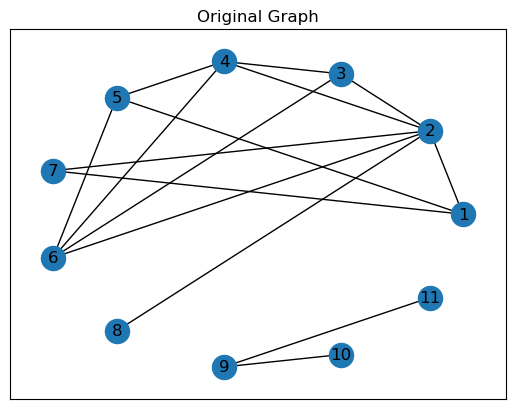

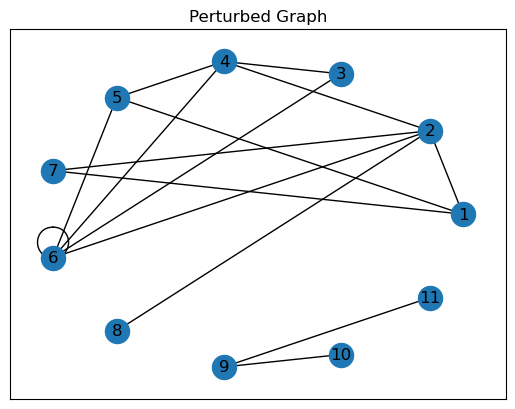

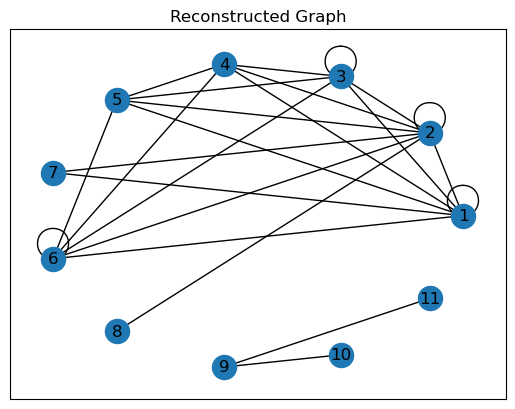

In [4]:
def build_noise_edge_havel_theorem(noisy_degree_sequence, perturbed_graph):
    """Build noise edge according to Havel's Theorem."""
    reconstructed_graph = perturbed_graph.copy()
    
    # Divide the elements in noisy degree sequence into positive and negative groups
    positive_group = [degree for degree in noisy_degree_sequence if degree > 0]
    negative_group = [abs(degree) for degree in noisy_degree_sequence if degree < 0]
    
    # Build disturbed edges for positive group according to Havel's Theorem
    for i in range(len(positive_group)):
        for j in range(i + 1, len(positive_group)):
            u, v = positive_group[i], positive_group[j]
            if not reconstructed_graph.has_edge(u, v):
                reconstructed_graph.add_edge(u, v)
    
    # Build disturbed edges for negative group according to Havel's Theorem
    for i in range(len(negative_group)):
        for j in range(i + 1, len(negative_group)):
            u, v = negative_group[i], negative_group[j]
            if reconstructed_graph.has_edge(u, v):
                reconstructed_graph.remove_edge(u, v)
    
    return reconstructed_graph

# Example usage
visualize_graph(original_graph_true, "Original Graph")
visualize_graph(perturbed_graph, "Perturbed Graph")
def test_build_noise_edge_havel_theorem():
    # Use the perturbed graph and its noisy degree sequence
    noisy_degree_sequence = [degree for _, degree in perturbed_graph.degree()]
    
    # Apply Havel's Theorem to build noise edges
    reconstructed_graph = build_noise_edge_havel_theorem(noisy_degree_sequence, perturbed_graph)
    
    # Visualize the reconstructed graph
    visualize_graph(reconstructed_graph, "Reconstructed Graph")

test_build_noise_edge_havel_theorem()


STEP 5: Now in this step we will be adding literally new nodes or might be deleting few with lower degrees(hence less usefull) 
If Laplace noise is negative:
i.e η4 < 0, it indicates that we need to remove nodes from G' to add noise.
We identify nodes in G' whose degrees are less than or equal to d_noise. These nodes are candidates for removal as they represent nodes with low connectivity.
We randomly select nodes from these candidates and remove them along with all their incident edges from G'. The number of nodes to remove is determined by the absolute value of η4.
Step 3: If Laplace noise is positive
i.e η4 > 0, it indicates that we need to add nodes and edges to G' to introduce noise.
We iterate η4 times, performing the following operations each time:
We create a virtual node, which will act as a connector node to introduce noise.
We randomly choose R true nodes from G' to connect with this virtual node. The value R is randomly chosen between 1 and d_noise.
We add edges between the virtual node and the selected true nodes to G'.


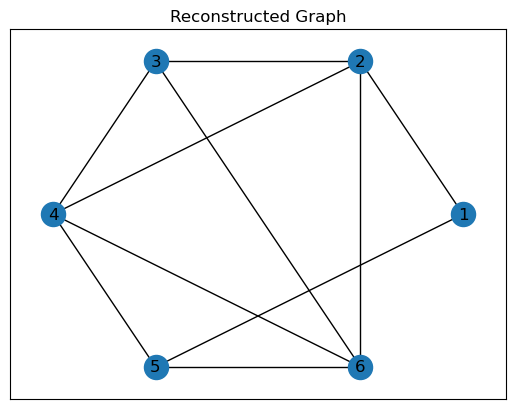

In [5]:
import random

def laplace_mechanism(epsilon):
    """Generate Laplace noise with scale 1/epsilon."""
    scale = 1 / epsilon
    return np.random.laplace(0, scale)

def post_processing_add_node_noises(graph, epsilon3, d_noise):
    """Post-processing algorithm by adding node noises."""
    reconstructed_graph = copy.deepcopy(graph)
    
    # Calculate Laplace noise
    eta4 = laplace_mechanism(epsilon3)
    
    # If Laplace noise is negative
    if eta4 < 0:
        # Find nodes with degree <= d_noise
        nodes_to_delete = [node for node, degree in graph.degree() if degree <= d_noise]
        
        # Randomly delete nodes and all edges connected to them |eta4| times
        for _ in range(int(abs(eta4))):
            if not nodes_to_delete:
                break
            node_to_delete = random.choice(nodes_to_delete)
            reconstructed_graph.remove_node(node_to_delete)
            nodes_to_delete.remove(node_to_delete)
    
    # If Laplace noise is positive
    elif eta4 > 0:
        # Perform the following operations |eta4| times
        for _ in range(int(eta4)):
            # Create a virtual node
            virtual_node = max(graph.nodes()) + 1
            
            # Randomly choose R true nodes to connect with the virtual node
            R = random.randint(1, d_noise)
            nodes_to_connect = random.sample(list(graph.nodes()), R)
            
            # Add connections to the virtual node
            for node in nodes_to_connect:
                reconstructed_graph.add_edge(virtual_node, node)
    
    return reconstructed_graph



example_graph = original_graph_true
    
# Privacy budget and threshold value
epsilon3 = 0.033
d_noise = 2
    
# Apply post-processing algorithm
reconstructed_graphv = post_processing_add_node_noises(example_graph, epsilon3, d_noise)
    
# Visualize the reconstructed graph
visualize_graph(reconstructed_graphv, "Reconstructed Graph")




STEP 6:
It's a kind of step where we anlayse our results.
We obtain a p value based on the few steps mentioned below. The closer it is to 1,the better is the model.
But it must be kept in mind that this value depends on lot of factors like
1)input graph
2)hyperparameter (like dnoise,error cost e2,e3)
3)Randomness (each time you run it you will obtain a diff performance)

In [6]:
def measure_algorithm_privacy(original_graph, disturbance_graph):
    """Measure algorithm for privacy protection based on adjacency degree."""
    # Step 1: Calculate the number of edges in the original and disturbance graphs
    m = original_graph.number_of_edges()
    m_prime = disturbance_graph.number_of_edges()
    
    # Step 2: Calculate the initial value of the number of different elements between two sequences
    D_diff = 2 * max(m, m_prime)
    
    # Step 3: Traverse all nodes in the original graph
    for node_u in original_graph.nodes():
        # Count the degree number of adjacent nodes of u in descending order
        link_u = sorted([degree for _, degree in original_graph.degree(original_graph.neighbors(node_u))], reverse=True)
        
        # Step 4: Traverse all nodes in the disturbance graph
        for node_u_prime in disturbance_graph.nodes():
            # Count the degree number of adjacent nodes of u' in descending order
            link_u_prime = sorted([degree for _, degree in disturbance_graph.degree(disturbance_graph.neighbors(node_u_prime))], reverse=True)
            
            # Step 4b: Compare links if the nodes are at the same position in the original and disturbance graphs
            if node_u == node_u_prime:
                for degree in link_u:
                    if degree in link_u_prime:
                        D_diff -= 1
    
    # Step 5: Calculate the privacy protection level P
    P = D_diff / (max(m, m_prime) * 2)
    
    return P

# Example usage
def test_measure_algorithm_privacy():
    # Example original and disturbance graphs
    original_graph_test = original_graph_true
    disturbance_graph_test = reconstructed_graphv
    
    # Measure privacy protection level
    privacy_level = measure_algorithm_privacy(original_graph, disturbance_graph_test)
    print("Privacy Protection Level:", privacy_level)

test_measure_algorithm_privacy()


Privacy Protection Level: 0.7
